# Notebook to train CNNs

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, accuracy_score, recall_score
from data_utils_torch import get_paths_and_labels, calculate_min_max, create_dataloader, extract_subject_id
from plotting_utils_torch import view_image, view_random_image, plot_loss_curves, make_confusion_matrix, view_image_data
from sklearn.model_selection import StratifiedGroupKFold
import gc
from tqdm.auto import tqdm
from monai.networks.nets import ResNet
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility    
seed = 10
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Set mixed precision     
USE_AMP = True if device.type == 'cuda' else False
scaler = GradScaler(enabled=USE_AMP)
print(f"Automatic Mixed Precision (AMP) enabled: {USE_AMP}")

Using device: cuda
Automatic Mixed Precision (AMP) enabled: True


In [9]:
NORMALIZATION = "mni_reg_CV" # Name of the directory with the datasets
DATASET = "smci_pmci" # Choose dataset: "smci_pmci" or "nc_ad"
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET images
BATCH_SIZE = 16 # Set batch size

USE_MASK = False # Set to True to use the ROI mask at the input-image level, False to use the whole brain

if USE_MASK:
    ROI_MASK_PATH = str(Path("/home/diogommiranda/tese/masks/ROI_MASK.nii"))
else:
    ROI_MASK_PATH = None

# Get train paths and labels to calculate minmax values
train_paths, train_labels, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

# Calculate minmax values for train set
minmax_min, minmax_max = calculate_min_max(train_paths)

# Create train dataset
train_data = create_dataloader(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max, 
    mask_path=ROI_MASK_PATH
    )

# Create test set with the minmax values from train
test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)
test_data = create_dataloader(
    paths=test_paths,
    labels=test_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=False,
    seed=None,
    min_val=minmax_min, 
    max_val=minmax_max,
    mask_path=ROI_MASK_PATH
    )

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/train...
    Found 575 files for class 'smci'
    Found 314 files for class 'pmci'
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/test...
    Found 143 files for class 'smci'
    Found 78 files for class 'pmci'


torch.Size([1, 91, 109, 91])


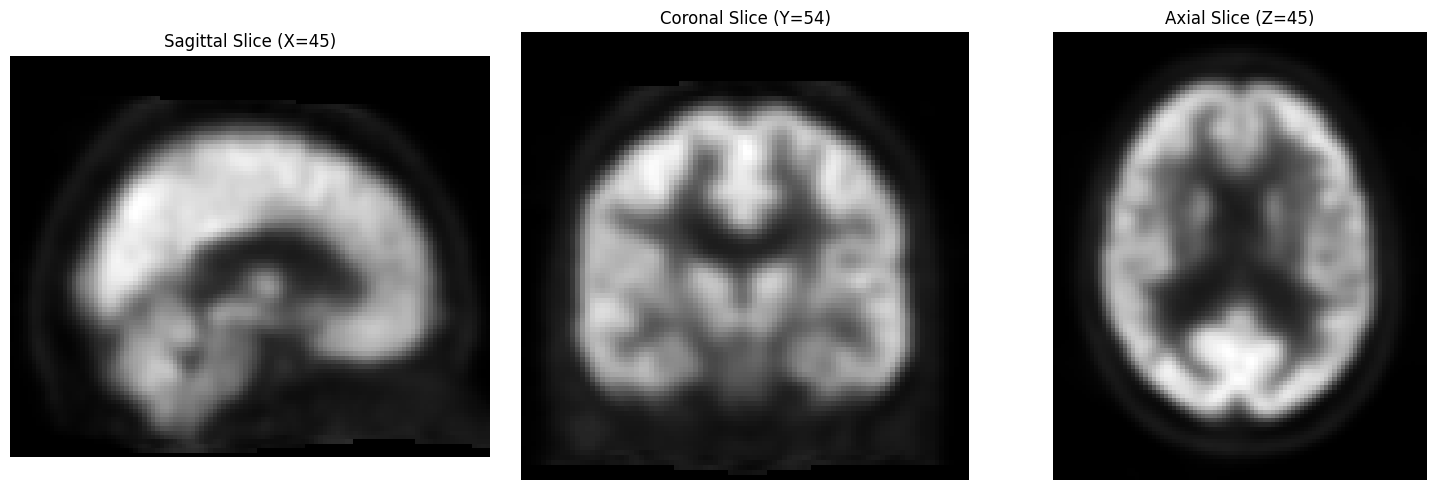

In [10]:
# Verify data with a test sample
i = 2
for data, label in test_data:
    view_image_data(data[i])
    #data[i] = torch.flip(data[i], dims=[3])
    #view_image_data(data[i])
    print(data[i].shape)
    break

# Nested Cross-Validation

In [ ]:
# ----- Hyperparameter Tuning with K-Fold Cross-Validation -----

N_SPLITS = 5 # Number of splits for cross-validation
NUM_EPOCHS = 300
EARLY_STOP_PATIENCE = 20
lr_scheduler = "fixed_lr" # Choose between "cosine_decay" or "fixed_lr"

use_optimizer = "adam" # Choose optimizer: "adam" or "sgd"
learning_rates = [2e-7]
weight_decays = [2e-4]

if lr_scheduler == "fixed_lr":
    dir2 = "fixed_lr/"
elif lr_scheduler == "cosine_decay":
    dir2 = "cosine_decay/"
    
if lr_scheduler == "cosine_decay":
    RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/full_brain/" + DATASET + "/" + dir2 + str(BATCH_SIZE) + "B/"
elif lr_scheduler == "fixed_lr":
    RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/full_brain/" + DATASET + "/" + dir2 + str(BATCH_SIZE) + "B/"
else:
    raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
print(f"Results will be saved to: {RESULTS_BASE_DIR}")

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

overall_start_time = time.time()

for current_lr in learning_rates:
    for current_wd in weight_decays: 
        print("=" * 60)
        print(f"Testing Combination: LR={current_lr:.1e}, WeightDecay={current_wd:.0e}")
        print("=" * 60)
        start_time_combination = time.time()

        #combo_dir_name = f"LR_{current_lr:.1e}_WD_{current_wd:.0e}"
        combo_dir_name = f"LR0_{current_lr:.1e}_WD_{current_wd:.0e}_NESTED_CV"
        combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)
        os.makedirs(combo_results_dir, exist_ok=True)
        print(f"  Saving results for this combo to: {combo_results_dir}")

        current_combo_val_losses = []
        current_combo_val_accuracies = []
        current_combo_val_aucs = []
        current_combo_best_epoch = []

        current_combo_test_losses = []
        current_combo_test_accuracies = []
        current_combo_test_aucs = []

        fold_no = 1

        # K-Fold Cross-Validation
        for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
            print("-" * 60)
            print(f"Training Fold {fold_no}/{N_SPLITS} for LR={current_lr:.1e} and WD={current_wd:.0e}...")
            start_time_fold = time.time()

            # Get paths and labels for the current fold
            fold_train_paths = train_paths[train_indices]
            fold_train_labels = train_labels[train_indices]
            fold_val_paths = train_paths[val_indices]
            fold_val_labels = train_labels[val_indices]

            # Verify subject separation
            train_subjects = set(subject_ids[train_indices])
            val_subjects = set(subject_ids[val_indices])
            if not train_subjects.isdisjoint(val_subjects):
                    raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")

            print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

            # Calculate minmax parameters for the current training fold
            fold_min, fold_max = calculate_min_max(fold_train_paths)

            # Create fold train dataset
            fold_train_data = create_dataloader(
                paths=fold_train_paths,
                labels=fold_train_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=True, 
                seed=seed,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            ) 
            
            # Create fold validation dataset
            fold_val_data = create_dataloader(
                paths=fold_val_paths,
                labels=fold_val_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False, 
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )
            
            test_data = create_dataloader(
                paths=test_paths,
                labels=test_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False,
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
                )

            if fold_train_data is None or fold_val_data is None or test_data is None:
                    raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")
                
            # Compute class weights for the current fold
            unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
            print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
            pos_weight_val = class_counts[0] / class_counts[1]
            pos_weight_val = torch.tensor([pos_weight_val], device=device)
            print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

            # Create the model
            model = ResNet(
                block='basic',
                layers=[3, 4, 6, 3],
                block_inplanes=[64, 128, 256, 512],
                spatial_dims=3,
                n_input_channels=1,
                conv1_t_stride=2,
                num_classes=1,
                shortcut_type='B',
                bias_downsample = False
            )
            model.to(device)

            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)
            
            if use_optimizer == "adam":
                optimizer = optim.Adam(model.parameters(), lr=current_lr, weight_decay=current_wd)
            elif use_optimizer == "sgd":
                optimizer = optim.SGD(model.parameters(), lr=current_lr, weight_decay=current_wd, momentum=0.9, nesterov=True)
                    
            scheduler = None
            if lr_scheduler == "cosine_decay":
                print("\nUsing Cosine Annealing LR Scheduler.\n")
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-8)

            best_val_loss = float('inf')
            epochs_no_improve = 0
            best_epoch = 0
            best_model_state = None
            stopped_epoch = NUM_EPOCHS 

            # Initialize history for this fold
            history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': []}

            for epoch in tqdm(range(NUM_EPOCHS)):
                epoch_start_time = time.time()
                history['epoch'].append(epoch + 1)

                # ---------------- Train phase ----------------
                model.train()
                
                running_loss = 0.0
                train_pred_probs = []
                train_targets = []
                
                for i, (inputs, labels) in enumerate(fold_train_data):
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)
                    
                    optimizer.zero_grad()
                    
                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    
                    prob_outputs = torch.sigmoid(outputs)
                    train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
                    train_targets.extend(labels.detach().cpu().numpy())

                train_targets = np.array(train_targets).flatten()
                train_pred_probs = np.array(train_pred_probs).flatten()
                
                # Calculate training metrics for the epoch
                train_loss = running_loss / len(fold_train_data.dataset)
                train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
                train_auc = roc_auc_score(train_targets, train_pred_probs)
                history['train_loss'].append(train_loss)
                history['train_accuracy'].append(train_acc)
                history['train_auc'].append(train_auc)

                # ---------------- Validation phase ----------------
                model.eval()
                val_running_loss = 0.0
                val_pred_probs = []
                val_targets = []

                with torch.inference_mode():
                    for inputs, labels in fold_val_data:
                        inputs = inputs.to(device)
                        labels = labels.float().unsqueeze(1).to(device)

                        # Mixed precision
                        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        val_running_loss += loss.item() * inputs.size(0)

                        prob_outputs = torch.sigmoid(outputs)
                        val_pred_probs.extend(prob_outputs.cpu().numpy())
                        val_targets.extend(labels.cpu().numpy())
                        
                val_targets = np.array(val_targets).flatten()
                val_pred_probs = np.array(val_pred_probs).flatten()

                # Calculate validation metrics for the epoch
                val_loss = val_running_loss / len(fold_val_data.dataset)
                val_acc = accuracy_score(val_targets, val_pred_probs >= 0.5)
                val_auc = roc_auc_score(val_targets, val_pred_probs)
                history['val_loss'].append(val_loss)
                history['val_accuracy'].append(val_acc)
                history['val_auc'].append(val_auc)

                # Print Epoch Summary
                epoch_duration = time.time() - epoch_start_time
                #print(f"    Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.2f}s] - "
                #        f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f} | "
                #        f"Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}")
                
                if scheduler:
                    scheduler.step()

                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    # Save the best model state
                    best_model_state = model.state_dict()
                    best_epoch = epoch + 1
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= EARLY_STOP_PATIENCE:
                    model.load_state_dict(best_model_state)
                    stopped_epoch = epoch + 1
                    print(f"\nEarly stopping triggered. Restoring best model weights from epoch {stopped_epoch - epochs_no_improve}.\n")
                    break
            
            # Restore the best model state if early stopping was not triggered
            if epochs_no_improve < EARLY_STOP_PATIENCE:
                print(f"Training completed for {NUM_EPOCHS} epochs. Restoring best model weights from epoch {best_epoch}.")
                model.load_state_dict(best_model_state)
            
            # Save fold history and plots
            fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
            os.makedirs(fold_dir, exist_ok=True)
            history_df = pd.DataFrame(history)
            history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
            history_df.to_csv(history_csv_path, index=False)
            plot_loss_curves(history, fold_dir)

            # Evaluate the fold
            best_epoch_index = np.argmin(history['val_loss'])
            best_epoch = best_epoch_index + 1
            val_loss_best = history['val_loss'][best_epoch_index]
            val_accuracy_best = history['val_accuracy'][best_epoch_index]
            val_auc_best = history['val_auc'][best_epoch_index]
            print(f"    Fold {fold_no} - Best Epoch {best_epoch}, Val Loss: {val_loss_best:.4f}, Acc: {val_accuracy_best:.4f}, AUC: {val_auc_best:.4f}")

            # Append results for this fold
            current_combo_val_losses.append(val_loss_best)
            current_combo_val_accuracies.append(val_accuracy_best)
            current_combo_val_aucs.append(val_auc_best)
            current_combo_best_epoch.append(best_epoch)
            
            optimizer_name = optimizer.__class__.__name__
            
            end_time_fold = time.time()
            print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
            fold_no += 1
            
            # ---------------- Evaluate the model on the test data ---------------- 
            model.eval()
            test_running_loss = 0.0
            test_pred_probs = []
            test_targets = []

            with torch.inference_mode():
                for inputs, labels in test_data:
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)

                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    test_running_loss += loss.item() * inputs.size(0)
                
                    prob_outputs = torch.sigmoid(outputs)
                    
                    test_pred_probs.extend(prob_outputs.cpu().numpy())
                    test_targets.extend(labels.cpu().numpy())

            test_targets = np.array(test_targets).flatten()
            test_pred_probs = np.array(test_pred_probs).flatten()

            # Calculate test loss and accuracy
            test_loss = test_running_loss / len(test_data.dataset)
            test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
            print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

            y_true = test_targets.astype(int)
            y_pred = test_pred_probs.round().astype(int)

            # Calculate metrics
            accuracy = test_acc
            sensitivity = recall_score(y_true, y_pred, pos_label=1)
            specificity = recall_score(y_true, y_pred, pos_label=0)
            bacc = balanced_accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, average='weighted')
            mcc = matthews_corrcoef(y_true, y_pred)
            auc_score = roc_auc_score(y_true, y_pred)
            
            class0, class1 = DATASET.split("_")
            target_names = [class0, class1]

            # Save the confusion matrix plot
            make_confusion_matrix(y_true=y_true,
                                y_pred=y_pred.round(),
                                classes=target_names,
                                figsize=(8, 8),
                                text_size=15,
                                save_dir=fold_dir)

            # Save the test loss and accuracy and the evaluation metrics
            result_file_path = os.path.join(fold_dir, "test_results.txt")
            with open(result_file_path, "w") as f:
                f.write(f"[{test_loss}, {test_acc}]\n\n")
                f.write("--- Evaluation Metrics on Test Set ---\n")
                f.write(f"Accuracy:    {accuracy:.4f}\n")
                f.write(f"Sensitivity: {sensitivity:.4f}\n")
                f.write(f"Specificity: {specificity:.4f}\n")
                f.write(f"Balanced Accuracy (BACC): {bacc:.4f}\n")
                f.write(f"F1 Score (Weighted):      {f1:.4f}\n")
                f.write(f"Matthews Corr Coef (MCC): {mcc:.4f}\n")
                f.write(f"Area Under the Curve (AUC): {auc_score:.4f}\n")
                
            test_config = {
                "num_epochs": int(best_epoch),
                "lr_scheduler": lr_scheduler,
                "optimizer": optimizer_name,
                "optimizer_params": {
                    "lr": float(current_lr),
                    "weight_decay": float(current_wd)
                },
                "batch_size": BATCH_SIZE,
                "seed": seed,
                "dataset": DATASET
            }
            params_file_path = os.path.join(fold_dir, "test_config.json")
            with open(params_file_path, "w") as f:
                json.dump(test_config, f, indent=4)
                    
            # Append results for this fold
            current_combo_test_losses.append(test_loss)
            current_combo_test_accuracies.append(test_acc)
            current_combo_test_aucs.append(auc_score)
            
            # Free resources
            del model, optimizer, criterion, scheduler, fold_train_data, fold_val_data, history, history_df, best_model_state
            if device.type == 'cuda':
                torch.cuda.empty_cache() 
            gc.collect() 

        end_time_combination = time.time()
        print(f"Combination finished in {end_time_combination - start_time_combination:.2f} seconds.")

        # Aggregate results across folds
        avg_loss = np.mean(current_combo_val_losses)
        std_loss = np.std(current_combo_val_losses)
        avg_acc = np.mean(current_combo_val_accuracies)
        std_acc = np.std(current_combo_val_accuracies)
        avg_auc = np.mean(current_combo_val_aucs)
        std_auc = np.std(current_combo_val_aucs)

        combo_average_results = {
            'learning_rate': current_lr,
            'weight_decay': current_wd,
            'avg_val_loss': avg_loss,
            'std_val_loss': std_loss,
            'avg_val_accuracy': avg_acc,
            'std_val_accuracy': std_acc,
            'avg_val_auc': avg_auc,
            'std_val_auc': std_auc,
            'individual_losses': [round(loss, 4) for loss in current_combo_val_losses],
            'individual_accuracies': [round(acc, 4) for acc in current_combo_val_accuracies],
            'individual_aucs': [round(auc, 4) for auc in current_combo_val_aucs],
            'best_epoch_per_fold': list(current_combo_best_epoch)
        }

        # Save results in a txt file and the parameters in a json file
        results_df = pd.DataFrame(combo_average_results)
        display_cols = list(combo_average_results.keys())

        val_results_filepath = os.path.join(combo_results_dir, "validation_results.txt")
        with open(val_results_filepath, "w") as f:
            print("Validation Results Summary:", file=f)
            print(results_df[display_cols].round(6).to_string(index=False), file=f)

            print(f"\nHyperparameters: LR={current_lr:.1e}, Weight_decay={current_wd:.0e}", file=f)

        avg_test_loss = np.mean(current_combo_test_losses)
        std_test_loss = np.std(current_combo_test_losses)
        avg_test_acc = np.mean(current_combo_test_accuracies)
        std_test_acc = np.std(current_combo_test_accuracies)
        avg_test_auc = np.mean(current_combo_test_aucs)
        std_test_auc = np.std(current_combo_test_aucs)

        combo_test_average_results = {
            'avg_test_loss': avg_test_loss,	
            'std_test_loss': std_test_loss,
            'avg_test_accuracy': avg_test_acc,
            'std_test_accuracy': std_test_acc,
            'avg_test_auc': avg_test_auc,
            'std_test_auc': std_test_auc,
            'individual_test_losses': [round(loss, 4) for loss in current_combo_test_losses],
            'individual_test_accuracies': [round(acc, 4) for acc in current_combo_test_accuracies],
            'individual_test_aucs': [round(auc, 4) for auc in current_combo_test_aucs]
        }
            
        test_results_df = pd.DataFrame(combo_test_average_results)
        display_cols = list(combo_test_average_results.keys())
        test_results_filepath = os.path.join(combo_results_dir, "average_test_results.txt")
        with open(test_results_filepath, "w") as f:
            print("Test Results Summary:", file=f)
            print(test_results_df[display_cols].round(6).to_string(index=False), file=f)

            print(f"\nHyperparameters: LR={current_lr:.1e}, Weight_decay={current_wd:.0e}", file=f)

        training_config = {
            "num_folds": N_SPLITS,
            "num_epochs": NUM_EPOCHS,
            "early_stop_patience": EARLY_STOP_PATIENCE,
            "lr_scheduler": lr_scheduler,
            "optimizer": optimizer_name,
            "optimizer_params": {
                "lr": float(current_lr),
                "weight_decay": float(current_wd)
            }, 
            "batch_size": BATCH_SIZE,
            "seed": seed,
            "dataset": DATASET
        }
        params_file_path = os.path.join(combo_results_dir, "training_config.json")
        with open(params_file_path, "w") as f:
            json.dump(training_config, f, indent=4)

Results will be saved to: /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/16B/
Testing Combination: LR=2.0e-07, WeightDecay=1e-02
  Saving results for this combo to: /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/16B/LR0_2.0e-07_WD_1e-02_NESTED_CV
------------------------------------------------------------
Training Fold 1/5 for LR=2.0e-07 and WD=1e-02...
  Train samples: 726, Validation samples: 163
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 472, 1: 254}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8583


 33%|███▎      | 100/300 [10:59<21:59,  6.60s/it]


Early stopping triggered. Restoring best model weights from epoch 81.

    Fold 1 - Best Epoch 81, Val Loss: 0.6299, Acc: 0.7975, AUC: 0.8601
    Fold 1 finished in 661.39 seconds.


Test Loss: 0.8488175437461197, Test Acc: 0.7737556561085973
------------------------------------------------------------
Training Fold 2/5 for LR=2.0e-07 and WD=1e-02...
  Train samples: 712, Validation samples: 177
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 460, 1: 252}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8254


 25%|██▌       | 75/300 [07:55<23:46,  6.34s/it]


Early stopping triggered. Restoring best model weights from epoch 56.

    Fold 2 - Best Epoch 56, Val Loss: 0.7212, Acc: 0.7175, AUC: 0.7942
    Fold 2 finished in 476.84 seconds.


Test Loss: 0.7815137022760659, Test Acc: 0.7285067873303167
------------------------------------------------------------
Training Fold 3/5 for LR=2.0e-07 and WD=1e-02...
  Train samples: 704, Validation samples: 185
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 452, 1: 252}
  Calculated pos_weight for BCEWithLogitsLoss: 1.7937


 30%|███       | 90/300 [09:45<22:46,  6.51s/it]


Early stopping triggered. Restoring best model weights from epoch 71.

    Fold 3 - Best Epoch 71, Val Loss: 0.4742, Acc: 0.8054, AUC: 0.9199
    Fold 3 finished in 587.22 seconds.


Test Loss: 0.7676127782234778, Test Acc: 0.751131221719457
------------------------------------------------------------
Training Fold 4/5 for LR=2.0e-07 and WD=1e-02...
  Train samples: 697, Validation samples: 192
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 449, 1: 248}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8105


 29%|██▊       | 86/300 [09:02<22:30,  6.31s/it]


Early stopping triggered. Restoring best model weights from epoch 67.

    Fold 4 - Best Epoch 67, Val Loss: 0.6737, Acc: 0.6875, AUC: 0.8050
    Fold 4 finished in 544.03 seconds.


Test Loss: 0.7829467468132261, Test Acc: 0.7149321266968326
------------------------------------------------------------
Training Fold 5/5 for LR=2.0e-07 and WD=1e-02...
  Train samples: 717, Validation samples: 172
Calculated Min: -0.3496308922767639, Max: 2.544045925140381
  Fold train label counts: {0: 467, 1: 250}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8680


 25%|██▌       | 75/300 [07:59<23:57,  6.39s/it]


Early stopping triggered. Restoring best model weights from epoch 56.

    Fold 5 - Best Epoch 56, Val Loss: 0.6318, Acc: 0.7907, AUC: 0.8597
    Fold 5 finished in 480.54 seconds.


Test Loss: 0.7949751351214103, Test Acc: 0.7239819004524887
Combination finished in 2756.88 seconds.


# Train the model with the best hyperparameters and evaluate it on the test set

In [4]:
if ROI_MASK_PATH is None:
    print("\nUsing full brain scan.\n")
else:
    print("\nUsing ROI mask.\n")


Using full brain scan.




Loading model weights to continue training for more epochs.
  Train label counts: {0: 575, 1: 314}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8312

Using SGD optimizer with LR=1.0e-05 and WD=2e-04.


 10%|█         | 1/10 [00:06<01:02,  6.91s/it]

    Epoch 1/10 [6.91s] - Train Loss: 0.18786, Train Acc: 0.97638


 20%|██        | 2/10 [00:13<00:54,  6.82s/it]

    Epoch 2/10 [6.76s] - Train Loss: 0.18965, Train Acc: 0.97075


 30%|███       | 3/10 [00:20<00:47,  6.78s/it]

    Epoch 3/10 [6.73s] - Train Loss: 0.19476, Train Acc: 0.97300


 40%|████      | 4/10 [00:27<00:41,  6.94s/it]

    Epoch 4/10 [7.17s] - Train Loss: 0.18047, Train Acc: 0.98088


 50%|█████     | 5/10 [00:34<00:33,  6.76s/it]

    Epoch 5/10 [6.45s] - Train Loss: 0.17769, Train Acc: 0.97638


 60%|██████    | 6/10 [00:40<00:26,  6.66s/it]

    Epoch 6/10 [6.47s] - Train Loss: 0.16433, Train Acc: 0.98425


 70%|███████   | 7/10 [00:46<00:19,  6.57s/it]

    Epoch 7/10 [6.37s] - Train Loss: 0.16492, Train Acc: 0.97975


 80%|████████  | 8/10 [00:53<00:13,  6.53s/it]

    Epoch 8/10 [6.46s] - Train Loss: 0.15411, Train Acc: 0.98988


 90%|█████████ | 9/10 [01:00<00:06,  6.71s/it]

    Epoch 9/10 [7.09s] - Train Loss: 0.15823, Train Acc: 0.97975


100%|██████████| 10/10 [01:06<00:00,  6.69s/it]

    Epoch 10/10 [6.49s] - Train Loss: 0.15815, Train Acc: 0.98538


Test Loss: 0.7132815640436578, Test Acc: 0.8009049773755657


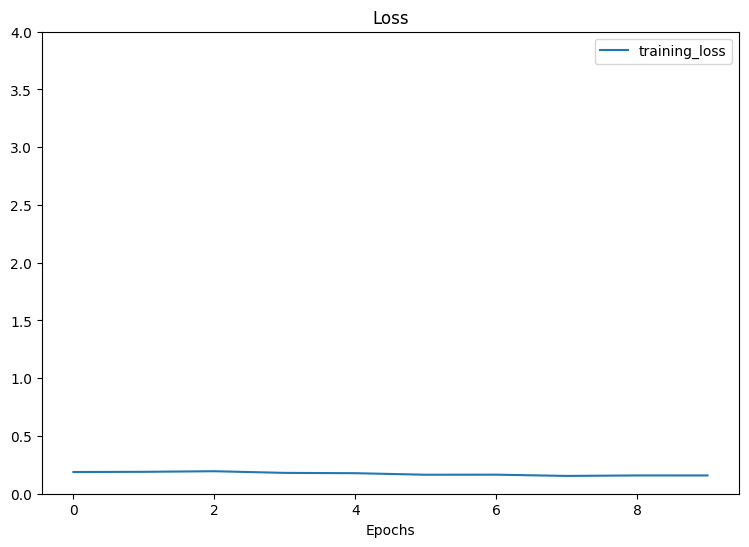

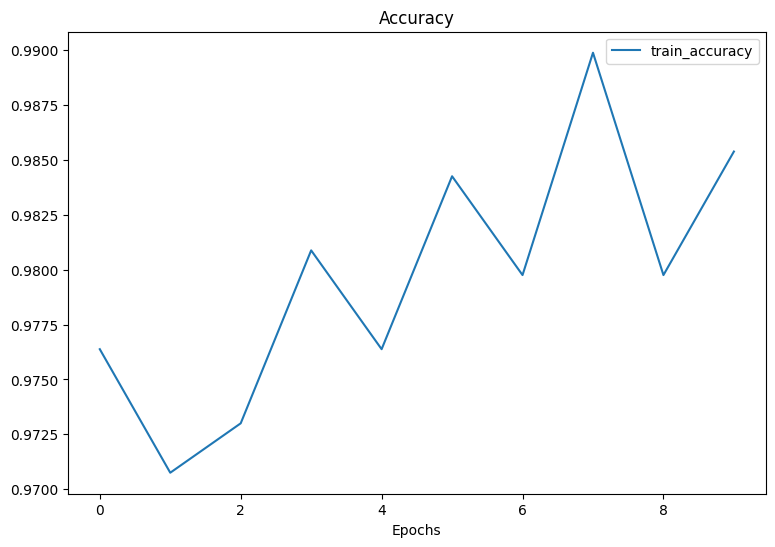

In [ ]:
# --- Train the model with the best hyperparameters and evaluate it on the test set ---

# Hyperparameters
use_optimizer = "sgd" # Choose between "adam" or "sgd"
BEST_LR = 1e-5 # learning rate
BEST_WD= 2e-4 # weight decay
BEST_NUM_EPOCHS = 10 # number of epochs for training
cosine_scheduler = False # Set to True if using cosine decay, False if using fixed learning rate
train_for_more_epochs = False
loading = False

if cosine_scheduler:
    print(f"Using cosine decay: {cosine_scheduler}")

# Filepath to save/load the model
SAVED_MODEL_FILEPATH = "/home/diogommiranda/tese/outputs/best_model.pth"
#SAVED_MODEL_FILEPATH = "/home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/saved_models/16B/LR=1.0e-05_WD=2e-04 (70)/model.pth"

# Create the model
model = ResNet(
    block='basic',
    layers=[3, 4, 6, 3],
    block_inplanes=[64, 128, 256, 512],
    spatial_dims=3,
    n_input_channels=1,
    conv1_t_stride=2,
    num_classes=1,
    shortcut_type='B',
    bias_downsample=False
)
model.to(device)

# Load saved model or train anew
if train_for_more_epochs:
    model.load_state_dict(torch.load(SAVED_MODEL_FILEPATH, weights_only=True, map_location=device)) # load model to continue training for more epochs
    print(f"\nLoading model weights to continue training for more epochs.")
else:
    print(f"\nTraining the model from scratch.")

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
print(f"  Train label counts: {dict(zip(unique_classes, class_counts))}")
pos_weight_val = class_counts[0] / class_counts[1]
pos_weight_val = torch.tensor([pos_weight_val], device=device)
print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)

if use_optimizer == "adam":
    print(f"\nUsing Adam optimizer with LR={BEST_LR:.1e} and WD={BEST_WD:.0e}.")
    optimizer = torch.optim.Adam(model.parameters(), lr=BEST_LR, weight_decay=BEST_WD)
elif use_optimizer == "sgd":
    print(f"\nUsing SGD optimizer with LR={BEST_LR:.1e} and WD={BEST_WD:.0e}.")
    optimizer = torch.optim.SGD(model.parameters(), lr=BEST_LR, weight_decay=BEST_WD, momentum=0.9, nesterov=True)

# Save optimizer name to use in the saving files
optimizer_name = optimizer.__class__.__name__

scheduler = None
if cosine_scheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-7) # T_max=100 for 100 epochs (used in CV)

history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': []}

for epoch in tqdm(range(BEST_NUM_EPOCHS)):
    epoch_start_time = time.time()
    history['epoch'].append(epoch + 1)

    model.train()
    running_loss = 0.0
    train_pred_probs = []
    train_targets = []

    for i, (inputs, labels) in enumerate(train_data):
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        
        prob_outputs = torch.sigmoid(outputs)
        train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
        train_targets.extend(labels.detach().cpu().numpy())

    train_targets = np.array(train_targets).flatten()
    train_pred_probs = np.array(train_pred_probs).flatten()
    
    # Calculate training metrics for the epoch
    train_loss = running_loss / len(train_data.dataset)
    train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
    train_auc = roc_auc_score(train_targets, train_pred_probs)
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['train_auc'].append(train_auc)
        
    epoch_duration = time.time() - epoch_start_time
    print(f"    Epoch {epoch+1}/{BEST_NUM_EPOCHS} [{epoch_duration:.2f}s] - Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f}")
    
    if scheduler:
        scheduler.step()

# Save the model if using fixed learning rate in case we want to continue training it
if not cosine_scheduler and not loading:
    torch.save(model.state_dict(), SAVED_MODEL_FILEPATH)
    print(f"Model saved to: {SAVED_MODEL_FILEPATH}")

plot_loss_curves(history)

# Evaluate the model on the test data
model.eval()
test_running_loss = 0.0
test_pred_probs = []
test_targets = []

with torch.inference_mode():
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
    
        prob_outputs = torch.sigmoid(outputs)
        
        test_pred_probs.extend(prob_outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_targets = np.array(test_targets).flatten()
test_pred_probs = np.array(test_pred_probs).flatten()

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_data.dataset)
test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")


--- Evaluation Metrics on Test Set ---
Accuracy:    0.8009
Sensitivity: 0.7564
Specificity: 0.8252 
Balanced Accuracy (BACC): 0.7908
F1 Score (Weighted):      0.8025
Matthews Corr Coef (MCC): 0.5726
Area Under the Curve (AUC): 0.7908



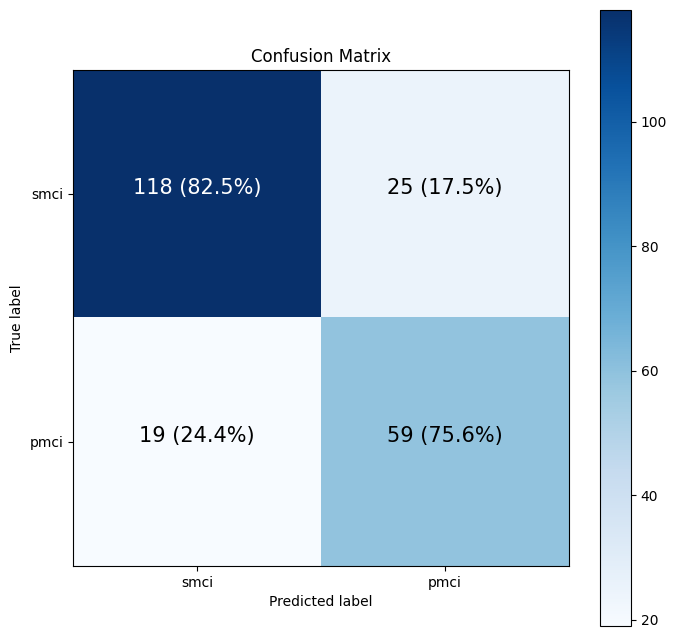

In [21]:
y_true = test_targets.astype(int)
y_pred = test_pred_probs.round().astype(int)

# Calculate metrics
accuracy = test_acc
sensitivity = recall_score(y_true, y_pred, pos_label=1)
specificity = recall_score(y_true, y_pred, pos_label=0)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true, y_pred, target_names, figsize=(8, 8), text_size=15)


# Save the model

In [ ]:
save_option = False # Set to True to save the model, confusion matrix, and evaluation metrics

if save_option:
    
    # Configure the right path
    if USE_MASK:
        dir1 = "masked/"
    else:
        dir1 = "full_brain/"
    if cosine_scheduler:
        dir2 = "cosine_decay/"
    else:
        dir2 = "fixed_lr/"
        
    if cosine_scheduler:
        lr_scheduler = "cosine_decay"
    else:
        lr_scheduler = "fixed_lr"
        
    save_model_dir = "/home/diogommiranda/tese/outputs/torch/" + dir1 + DATASET + "/" + dir2 + "saved_models/" + str(BATCH_SIZE) + "B" + f"/LR={BEST_LR:.1e}_WD={BEST_WD:.0e}"
    print(f"Saving model to: {save_model_dir}")
    os.makedirs(save_model_dir, exist_ok=True)

    # Save the model
    torch.save(model.state_dict(), os.path.join(save_model_dir, "model.pth"))

    # Save the confusion matrix plot
    make_confusion_matrix(y_true=y_true,
                        y_pred=y_pred.round(),
                        classes=target_names,
                        figsize=(8, 8),
                        text_size=15,
                        save_dir=save_model_dir)

    # Save the test loss and accuracy and the evaluation metrics
    result_file_path = os.path.join(save_model_dir, "resultados.txt")
    with open(result_file_path, "w") as f:
        f.write(f"[{test_loss}, {test_acc}]\n\n")
        f.write("--- Evaluation Metrics on Test Set ---\n")
        f.write(f"Accuracy:    {accuracy:.4f}\n")
        f.write(f"Sensitivity: {sensitivity:.4f}\n")
        f.write(f"Specificity: {specificity:.4f}\n")
        f.write(f"Balanced Accuracy (BACC): {bacc:.4f}\n")
        f.write(f"F1 Score (Weighted):      {f1:.4f}\n")
        f.write(f"Matthews Corr Coef (MCC): {mcc:.4f}\n")
        f.write(f"Area Under the Curve (AUC): {auc_score:.4f}\n")
        
    training_config = {
        "num_epochs": BEST_NUM_EPOCHS,
        "lr_scheduler": lr_scheduler,
        "optimizer": optimizer_name,
        "optimizer_params": {
            "lr": float(BEST_LR),
            "weight_decay": float(BEST_WD)
        },
        "batch_size": BATCH_SIZE,
        "seed": seed,
        "dataset": DATASET
    }
    params_file_path = os.path.join(save_model_dir, "training_config.json")
    with open(params_file_path, "w") as f:
        json.dump(training_config, f, indent=4)

Saving model to: /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/saved_models/16B/LR=1.0e-05_WD=2e-04


# Load a model and try it

  Train label counts: {0: 575, 1: 314}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8312
Test Loss: 0.7523062952638212, Test Acc: 0.8099547511312217

--- Evaluation Metrics on Test Set ---
Accuracy:    0.8100
Sensitivity: 0.7436
Specificity: 0.8462 
Balanced Accuracy (BACC): 0.7949
F1 Score (Weighted):      0.8105
Matthews Corr Coef (MCC): 0.5864
Area Under the Curve (AUC): 0.7949



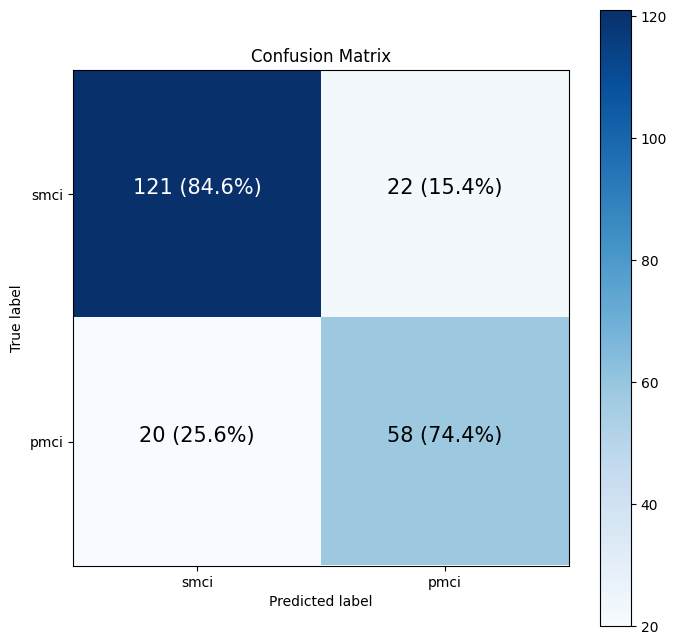

In [ ]:
load_model = ResNet(
        block='basic',
        layers=[3, 4, 6, 3],
        block_inplanes=[64, 128, 256, 512],
        spatial_dims=3,
        n_input_channels=1,
        conv1_t_stride=2,
        num_classes=1,
        shortcut_type='B',
        bias_downsample=False
        )
load_model.to(device)
save_model_dir = "/home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/saved_models/LR=1.0e-05_WD=1e-04 (sgd) (4B)"
load_model.load_state_dict(torch.load(os.path.join(save_model_dir, "model.pth"), map_location=device))

# Compute class weights
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
print(f"  Train label counts: {dict(zip(unique_classes, class_counts))}")
pos_weight_val = class_counts[0] / class_counts[1]
pos_weight_val = torch.tensor([pos_weight_val], device=device)
print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)

# Evaluate the model on the test data
load_model.eval()
test_running_loss = 0.0
test_pred_probs = []
test_targets = []

with torch.inference_mode():
    for inputs, labels in test_data:
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        # Mixed precision
        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
            outputs = load_model(inputs)
            loss = criterion(outputs, labels)

        test_running_loss += loss.item() * inputs.size(0)
    
        prob_outputs = torch.sigmoid(outputs)
        
        test_pred_probs.extend(prob_outputs.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_targets = np.array(test_targets).flatten()
test_pred_probs = np.array(test_pred_probs).flatten()

# Calculate test loss and accuracy
test_loss = test_running_loss / len(test_data.dataset)
test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

y_true = test_targets.astype(int)
y_pred = test_pred_probs.round().astype(int)

# Calculate metrics
accuracy = test_acc
sensitivity = recall_score(y_true, y_pred, pos_label=1)
specificity = recall_score(y_true, y_pred, pos_label=0)
bacc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
mcc = matthews_corrcoef(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

print("\n--- Evaluation Metrics on Test Set ---")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f} ")
print(f"Balanced Accuracy (BACC): {bacc:.4f}")
print(f"F1 Score (Weighted):      {f1:.4f}") 
print(f"Matthews Corr Coef (MCC): {mcc:.4f}")
print(f"Area Under the Curve (AUC): {auc_score:.4f}\n")

class0, class1 = DATASET.split("_")
target_names = [class0, class1]

make_confusion_matrix(y_true, y_pred, target_names, figsize=(8, 8), text_size=15)


# Nested Cross-Validation

In [4]:
# ----- Hyperparameter Tuning with K-Fold Cross-Validation -----

N_SPLITS = 5 # Number of splits for cross-validation
NUM_EPOCHS = 300
EARLY_STOP_PATIENCE = 70
lr_scheduler = "fixed_lr" # Choose between "cosine_decay" or "fixed_lr"

use_optimizer = "sgd" # Choose optimizer: "adam" or "sgd"
learning_rates = [1e-5]
weight_decays = [2e-4]

if lr_scheduler == "fixed_lr":
    dir2 = "fixed_lr/"
elif lr_scheduler == "cosine_decay":
    dir2 = "cosine_decay/"
    
if lr_scheduler == "cosine_decay":
    RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/full_brain/" + DATASET + "/" + dir2 + str(BATCH_SIZE) + "B/"
elif lr_scheduler == "fixed_lr":
    RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/torch/full_brain/" + DATASET + "/" + dir2 + str(BATCH_SIZE) + "B/"
else:
    raise ValueError("Invalid string for 'lr_scheduler'. Please set it to 'cosine_decay' or 'fixed_lr'.")
os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
print(f"Results will be saved to: {RESULTS_BASE_DIR}")

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

overall_start_time = time.time()

for current_lr in learning_rates:
    for current_wd in weight_decays: 
        print("=" * 60)
        print(f"Testing Combination: LR={current_lr:.1e}, WeightDecay={current_wd:.0e}")
        print("=" * 60)
        start_time_combination = time.time()

        #combo_dir_name = f"LR_{current_lr:.1e}_WD_{current_wd:.0e}"
        combo_dir_name = f"LR0_{current_lr:.1e}_WD_{current_wd:.0e}_NESTED_CV"
        combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)
        os.makedirs(combo_results_dir, exist_ok=True)
        print(f"  Saving results for this combo to: {combo_results_dir}")

        current_combo_val_losses = []
        current_combo_val_accuracies = []
        current_combo_val_aucs = []
        current_combo_best_epoch = []

        current_combo_test_losses = []
        current_combo_test_accuracies = []
        current_combo_test_aucs = []

        fold_no = 1

        # K-Fold Cross-Validation
        for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
            print("-" * 60)
            print(f"Training Fold {fold_no}/{N_SPLITS} for LR={current_lr:.1e} and WD={current_wd:.0e}...")
            start_time_fold = time.time()

            # Get paths and labels for the current fold
            fold_train_paths = train_paths[train_indices]
            fold_train_labels = train_labels[train_indices]
            fold_val_paths = train_paths[val_indices]
            fold_val_labels = train_labels[val_indices]

            # Verify subject separation
            train_subjects = set(subject_ids[train_indices])
            val_subjects = set(subject_ids[val_indices])
            if not train_subjects.isdisjoint(val_subjects):
                    raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")

            print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

            # Calculate minmax parameters for the current training fold
            fold_min, fold_max = calculate_min_max(fold_train_paths)

            # Create fold train dataset
            fold_train_data = create_dataloader(
                paths=fold_train_paths,
                labels=fold_train_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=True, 
                seed=seed,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            ) 
            
            # Create fold validation dataset
            fold_val_data = create_dataloader(
                paths=fold_val_paths,
                labels=fold_val_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False, 
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
            )
            
            test_data = create_dataloader(
                paths=test_paths,
                labels=test_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False,
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                mask_path=ROI_MASK_PATH
                )

            if fold_train_data is None or fold_val_data is None or test_data is None:
                    raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")
                
            # Compute class weights for the current fold
            unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
            print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
            pos_weight_val = class_counts[0] / class_counts[1]
            pos_weight_val = torch.tensor([pos_weight_val], device=device)
            print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

            # Create the model
            model = ResNet(
                block='basic',
                layers=[3, 4, 6, 3],
                block_inplanes=[64, 128, 256, 512],
                spatial_dims=3,
                n_input_channels=1,
                conv1_t_stride=2,
                num_classes=1,
                shortcut_type='B',
                bias_downsample = False
            )
            model.to(device)

            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)
            
            if use_optimizer == "adam":
                optimizer = optim.Adam(model.parameters(), lr=current_lr, weight_decay=current_wd)
            elif use_optimizer == "sgd":
                optimizer = optim.SGD(model.parameters(), lr=current_lr, weight_decay=current_wd, momentum=0.9, nesterov=True)
                    
            scheduler = None
            if lr_scheduler == "cosine_decay":
                print("\nUsing Cosine Annealing LR Scheduler.\n")
                scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-8)

            best_val_loss = float('inf')
            epochs_no_improve = 0
            best_epoch = 0
            best_model_state = None
            stopped_epoch = NUM_EPOCHS 

            # Initialize history for this fold
            history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': []}

            for epoch in tqdm(range(NUM_EPOCHS)):
                epoch_start_time = time.time()
                history['epoch'].append(epoch + 1)

                # ---------------- Train phase ----------------
                model.train()
                
                running_loss = 0.0
                train_pred_probs = []
                train_targets = []
                
                for i, (inputs, labels) in enumerate(fold_train_data):
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)
                    
                    optimizer.zero_grad()
                    
                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    
                    prob_outputs = torch.sigmoid(outputs)
                    train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
                    train_targets.extend(labels.detach().cpu().numpy())

                train_targets = np.array(train_targets).flatten()
                train_pred_probs = np.array(train_pred_probs).flatten()
                
                # Calculate training metrics for the epoch
                train_loss = running_loss / len(fold_train_data.dataset)
                train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
                train_auc = roc_auc_score(train_targets, train_pred_probs)
                history['train_loss'].append(train_loss)
                history['train_accuracy'].append(train_acc)
                history['train_auc'].append(train_auc)

                # ---------------- Validation phase ----------------
                model.eval()
                val_running_loss = 0.0
                val_pred_probs = []
                val_targets = []

                with torch.inference_mode():
                    for inputs, labels in fold_val_data:
                        inputs = inputs.to(device)
                        labels = labels.float().unsqueeze(1).to(device)

                        # Mixed precision
                        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        val_running_loss += loss.item() * inputs.size(0)

                        prob_outputs = torch.sigmoid(outputs)
                        val_pred_probs.extend(prob_outputs.cpu().numpy())
                        val_targets.extend(labels.cpu().numpy())
                        
                val_targets = np.array(val_targets).flatten()
                val_pred_probs = np.array(val_pred_probs).flatten()

                # Calculate validation metrics for the epoch
                val_loss = val_running_loss / len(fold_val_data.dataset)
                val_acc = accuracy_score(val_targets, val_pred_probs >= 0.5)
                val_auc = roc_auc_score(val_targets, val_pred_probs)
                history['val_loss'].append(val_loss)
                history['val_accuracy'].append(val_acc)
                history['val_auc'].append(val_auc)

                # Print Epoch Summary
                epoch_duration = time.time() - epoch_start_time
                #print(f"    Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.2f}s] - "
                #        f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f} | "
                #        f"Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}")
                
                if scheduler:
                    scheduler.step()

                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    # Save the best model state
                    best_model_state = model.state_dict()
                    best_epoch = epoch + 1
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= EARLY_STOP_PATIENCE:
                    model.load_state_dict(best_model_state)
                    stopped_epoch = epoch + 1
                    print(f"\nEarly stopping triggered. Restoring best model weights from epoch {stopped_epoch - epochs_no_improve}.\n")
                    break
            
            # Restore the best model state if early stopping was not triggered
            if epochs_no_improve < EARLY_STOP_PATIENCE:
                print(f"Training completed for {NUM_EPOCHS} epochs. Restoring best model weights from epoch {best_epoch}.")
                model.load_state_dict(best_model_state)
            
            # Save fold history and plots
            fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
            os.makedirs(fold_dir, exist_ok=True)
            history_df = pd.DataFrame(history)
            history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
            history_df.to_csv(history_csv_path, index=False)
            plot_loss_curves(history, fold_dir)

            # Evaluate the fold
            best_epoch_index = np.argmin(history['val_loss'])
            best_epoch = best_epoch_index + 1
            val_loss_best = history['val_loss'][best_epoch_index]
            val_accuracy_best = history['val_accuracy'][best_epoch_index]
            val_auc_best = history['val_auc'][best_epoch_index]
            print(f"    Fold {fold_no} - Best Epoch {best_epoch}, Val Loss: {val_loss_best:.4f}, Acc: {val_accuracy_best:.4f}, AUC: {val_auc_best:.4f}")

            # Append results for this fold
            current_combo_val_losses.append(val_loss_best)
            current_combo_val_accuracies.append(val_accuracy_best)
            current_combo_val_aucs.append(val_auc_best)
            current_combo_best_epoch.append(best_epoch)
            
            optimizer_name = optimizer.__class__.__name__
            
            end_time_fold = time.time()
            print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
            fold_no += 1
            
            # ---------------- Evaluate the model on the test data ---------------- 
            model.eval()
            test_running_loss = 0.0
            test_pred_probs = []
            test_targets = []

            with torch.inference_mode():
                for inputs, labels in test_data:
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)

                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    test_running_loss += loss.item() * inputs.size(0)
                
                    prob_outputs = torch.sigmoid(outputs)
                    
                    test_pred_probs.extend(prob_outputs.cpu().numpy())
                    test_targets.extend(labels.cpu().numpy())

            test_targets = np.array(test_targets).flatten()
            test_pred_probs = np.array(test_pred_probs).flatten()

            # Calculate test loss and accuracy
            test_loss = test_running_loss / len(test_data.dataset)
            test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)
            print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

            y_true = test_targets.astype(int)
            y_pred = test_pred_probs.round().astype(int)

            # Calculate metrics
            accuracy = test_acc
            sensitivity = recall_score(y_true, y_pred, pos_label=1)
            specificity = recall_score(y_true, y_pred, pos_label=0)
            bacc = balanced_accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, average='weighted')
            mcc = matthews_corrcoef(y_true, y_pred)
            auc_score = roc_auc_score(y_true, y_pred)
            
            class0, class1 = DATASET.split("_")
            target_names = [class0, class1]

            # Save the confusion matrix plot
            make_confusion_matrix(y_true=y_true,
                                y_pred=y_pred.round(),
                                classes=target_names,
                                figsize=(8, 8),
                                text_size=15,
                                save_dir=fold_dir)

            # Save the test loss and accuracy and the evaluation metrics
            result_file_path = os.path.join(fold_dir, "test_results.txt")
            with open(result_file_path, "w") as f:
                f.write(f"[{test_loss}, {test_acc}]\n\n")
                f.write("--- Evaluation Metrics on Test Set ---\n")
                f.write(f"Accuracy:    {accuracy:.4f}\n")
                f.write(f"Sensitivity: {sensitivity:.4f}\n")
                f.write(f"Specificity: {specificity:.4f}\n")
                f.write(f"Balanced Accuracy (BACC): {bacc:.4f}\n")
                f.write(f"F1 Score (Weighted):      {f1:.4f}\n")
                f.write(f"Matthews Corr Coef (MCC): {mcc:.4f}\n")
                f.write(f"Area Under the Curve (AUC): {auc_score:.4f}\n")
                
            test_config = {
                "num_epochs": int(best_epoch),
                "lr_scheduler": lr_scheduler,
                "optimizer": optimizer_name,
                "optimizer_params": {
                    "lr": float(current_lr),
                    "weight_decay": float(current_wd)
                },
                "batch_size": BATCH_SIZE,
                "seed": seed,
                "dataset": DATASET
            }
            params_file_path = os.path.join(fold_dir, "test_config.json")
            with open(params_file_path, "w") as f:
                json.dump(test_config, f, indent=4)
                    
            # Append results for this fold
            current_combo_test_losses.append(test_loss)
            current_combo_test_accuracies.append(test_acc)
            current_combo_test_aucs.append(auc_score)
            
            # Free resources
            del model, optimizer, criterion, scheduler, fold_train_data, fold_val_data, history, history_df, best_model_state
            if device.type == 'cuda':
                torch.cuda.empty_cache() 
            gc.collect() 

        end_time_combination = time.time()
        print(f"Combination finished in {end_time_combination - start_time_combination:.2f} seconds.")

        # Aggregate results across folds
        avg_loss = np.mean(current_combo_val_losses)
        std_loss = np.std(current_combo_val_losses)
        avg_acc = np.mean(current_combo_val_accuracies)
        std_acc = np.std(current_combo_val_accuracies)
        avg_auc = np.mean(current_combo_val_aucs)
        std_auc = np.std(current_combo_val_aucs)

        combo_average_results = {
            'learning_rate': current_lr,
            'weight_decay': current_wd,
            'avg_val_loss': avg_loss,
            'std_val_loss': std_loss,
            'avg_val_accuracy': avg_acc,
            'std_val_accuracy': std_acc,
            'avg_val_auc': avg_auc,
            'std_val_auc': std_auc,
            'individual_losses': [round(loss, 4) for loss in current_combo_val_losses],
            'individual_accuracies': [round(acc, 4) for acc in current_combo_val_accuracies],
            'individual_aucs': [round(auc, 4) for auc in current_combo_val_aucs],
            'best_epoch_per_fold': list(current_combo_best_epoch)
        }

        # Save results in a txt file and the parameters in a json file
        results_df = pd.DataFrame(combo_average_results)
        display_cols = list(combo_average_results.keys())

        val_results_filepath = os.path.join(combo_results_dir, "validation_results.txt")
        with open(val_results_filepath, "w") as f:
            print("Validation Results Summary:", file=f)
            print(results_df[display_cols].round(6).to_string(index=False), file=f)

            print(f"\nHyperparameters: LR={current_lr:.1e}, Weight_decay={current_wd:.0e}", file=f)

        avg_test_loss = np.mean(current_combo_test_losses)
        std_test_loss = np.std(current_combo_test_losses)
        avg_test_acc = np.mean(current_combo_test_accuracies)
        std_test_acc = np.std(current_combo_test_accuracies)
        avg_test_auc = np.mean(current_combo_test_aucs)
        std_test_auc = np.std(current_combo_test_aucs)

        combo_test_average_results = {
            'avg_test_loss': avg_test_loss,	
            'std_test_loss': std_test_loss,
            'avg_test_accuracy': avg_test_acc,
            'std_test_accuracy': std_test_acc,
            'avg_test_auc': avg_test_auc,
            'std_test_auc': std_test_auc,
            'individual_test_losses': [round(loss, 4) for loss in current_combo_test_losses],
            'individual_test_accuracies': [round(acc, 4) for acc in current_combo_test_accuracies],
            'individual_test_aucs': [round(auc, 4) for auc in current_combo_test_aucs]
        }
            
        test_results_df = pd.DataFrame(combo_test_average_results)
        display_cols = list(combo_test_average_results.keys())
        test_results_filepath = os.path.join(combo_results_dir, "average_test_results.txt")
        with open(test_results_filepath, "w") as f:
            print("Test Results Summary:", file=f)
            print(test_results_df[display_cols].round(6).to_string(index=False), file=f)

            print(f"\nHyperparameters: LR={current_lr:.1e}, Weight_decay={current_wd:.0e}", file=f)

        training_config = {
            "num_folds": N_SPLITS,
            "num_epochs": NUM_EPOCHS,
            "early_stop_patience": EARLY_STOP_PATIENCE,
            "lr_scheduler": lr_scheduler,
            "optimizer": optimizer_name,
            "optimizer_params": {
                "lr": float(current_lr),
                "weight_decay": float(current_wd)
            }, 
            "batch_size": BATCH_SIZE,
            "seed": seed,
            "dataset": DATASET
        }
        params_file_path = os.path.join(combo_results_dir, "training_config.json")
        with open(params_file_path, "w") as f:
            json.dump(training_config, f, indent=4)

Results will be saved to: /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/16B/
Testing Combination: LR=1.0e-05, WeightDecay=2e-04
  Saving results for this combo to: /home/diogommiranda/tese/outputs/torch/full_brain/smci_pmci/fixed_lr/16B/LR0_1.0e-05_WD_2e-04_NESTED_CV
------------------------------------------------------------
Training Fold 1/5 for LR=1.0e-05 and WD=2e-04...
  Train samples: 726, Validation samples: 163
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 472, 1: 254}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8583


 51%|█████     | 153/300 [16:06<15:28,  6.32s/it]


Early stopping triggered. Restoring best model weights from epoch 84.

    Fold 1 - Best Epoch 84, Val Loss: 0.6108, Acc: 0.8282, AUC: 0.8730
    Fold 1 finished in 968.03 seconds.


Test Loss: 0.8502377794878515, Test Acc: 0.7420814479638009
------------------------------------------------------------
Training Fold 2/5 for LR=1.0e-05 and WD=2e-04...
  Train samples: 712, Validation samples: 177
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 460, 1: 252}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8254


 47%|████▋     | 140/300 [14:23<16:26,  6.17s/it]


Early stopping triggered. Restoring best model weights from epoch 71.

    Fold 2 - Best Epoch 71, Val Loss: 0.7184, Acc: 0.6723, AUC: 0.7818
    Fold 2 finished in 864.48 seconds.


Test Loss: 0.8826954413323381, Test Acc: 0.746606334841629
------------------------------------------------------------
Training Fold 3/5 for LR=1.0e-05 and WD=2e-04...
  Train samples: 704, Validation samples: 185
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 452, 1: 252}
  Calculated pos_weight for BCEWithLogitsLoss: 1.7937


 61%|██████    | 182/300 [18:50<12:13,  6.21s/it]


Early stopping triggered. Restoring best model weights from epoch 113.

    Fold 3 - Best Epoch 113, Val Loss: 0.4458, Acc: 0.8486, AUC: 0.9364
    Fold 3 finished in 1131.99 seconds.


Test Loss: 0.7816077772848207, Test Acc: 0.7737556561085973
------------------------------------------------------------
Training Fold 4/5 for LR=1.0e-05 and WD=2e-04...
  Train samples: 697, Validation samples: 192
Calculated Min: -0.35769128799438477, Max: 2.7912356853485107
  Fold train label counts: {0: 449, 1: 248}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8105


 56%|█████▌    | 168/300 [17:14<13:33,  6.16s/it]


Early stopping triggered. Restoring best model weights from epoch 99.

    Fold 4 - Best Epoch 99, Val Loss: 0.6432, Acc: 0.7604, AUC: 0.8373
    Fold 4 finished in 1036.26 seconds.


Test Loss: 0.7656443750157076, Test Acc: 0.7963800904977375
------------------------------------------------------------
Training Fold 5/5 for LR=1.0e-05 and WD=2e-04...
  Train samples: 717, Validation samples: 172
Calculated Min: -0.3496308922767639, Max: 2.544045925140381
  Fold train label counts: {0: 467, 1: 250}
  Calculated pos_weight for BCEWithLogitsLoss: 1.8680


 59%|█████▊    | 176/300 [18:13<12:50,  6.21s/it]


Early stopping triggered. Restoring best model weights from epoch 107.

    Fold 5 - Best Epoch 107, Val Loss: 0.5979, Acc: 0.7965, AUC: 0.8701
    Fold 5 finished in 1095.12 seconds.


Test Loss: 0.872535002177657, Test Acc: 0.7873303167420814
Combination finished in 5102.52 seconds.
